In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [4]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    items = np.array(items_weights['item_id'])
    weights = np.array(items_weights['weight'])
    recs = np.random.choice(items, size=n, replace=False, p=weights)
    
    return recs.tolist()

In [5]:
popularity = data_train.groupby('item_id')['sales_value'].sum().reset_index()
popularity.sort_values('sales_value', ascending=False, inplace=True)
# поскольку сумма весов должна быть равна 1, удобнее присвоить веса исходя из доли в общей сумме продаж:
popularity['weight'] = popularity['sales_value'] / popularity['sales_value'].sum()
popularity['weight'].sum()

1.0

In [6]:
items_weights = popularity.copy()
items_weights.drop('sales_value', axis=1, inplace=True)

In [7]:
result = pd.read_csv('predictions_basic.csv')
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]"


In [8]:
%%time
result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))

Wall time: 3.26 s


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [9]:
#result = pd.read_csv('../predictions/predictions_basic.csv')
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,[ 821867 834484 856942 865456 889248 ...,"[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]","[12670788, 6534178, 856772, 883404, 1095100]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]","[830304, 948670, 865178, 1075998, 968215]"
2,6,[ 920308 926804 946489 1006718 1017061 ...,"[5129567, 6555376, 9487756, 6533880, 1117945]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1082185, 1029743, 6534178, 1127831, 995785]","[12810399, 6534178, 10284879, 847239, 847207]"
3,7,[ 840386 889774 898068 909714 929067 ...,"[15740824, 9423981, 1052258, 13986798, 1003354]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 961554, 1098066]","[1082185, 981760, 1127831, 961554, 826249]","[1082185, 1029743, 1127831, 995785, 1044078]","[1033977, 7168892, 7025046, 933835, 891505]"
4,8,[ 835098 872137 910439 924610 992977 ...,"[1964658, 954745, 976261, 7025202, 1054432]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 1029743, 1098066, 6534178, 1127831]","[1119860, 866878, 9527066, 871756, 831407]"


In [10]:
# поскольку элементы получились строками, преобразуем их:
for i in range(result.shape[0]):
    result['actual'][i] = [int(x) for x in result['actual'][i].replace("[", "").replace("]", "").replace("\n", "").replace(",", " ").replace("   ", " ").replace("  ", " ").split(" ")[1:]]
    result['random_recommendation'][i] = [int(x) for x in result['random_recommendation'][i][1:-1].split(", ")]
    result['popular_recommendation'][i] = [int(x) for x in result['popular_recommendation'][i][1:-1].split(", ")]
    result['itemitem'][i] = [int(x) for x in result['itemitem'][i][1:-1].split(", ")]
    result['cosine'][i] = [int(x) for x in result['cosine'][i][1:-1].split(", ")]
    result['tfidf'][i] = [int(x) for x in result['tfidf'][i][1:-1].split(", ")]
    result['own_purchases'][i] = [int(x) for x in result['own_purchases'][i].replace("[", "").replace("]", "").replace("\n", "").replace(",", " ").replace("   ", " ").replace("  ", " ").split(" ")[1:]]
    #result['weighted_random_recommendation'][i] = [int(x) for x in result['weighted_random_recommendation'][i]]
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1029743, 995785, 1004906, 1081177]","[12670788, 6534178, 856772, 883404, 1095100]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1098066, 6534178, 1127831, 1068719]","[830304, 948670, 865178, 1075998, 968215]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[5129567, 6555376, 9487756, 6533880, 1117945]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1029743, 6534178, 1127831, 995785]","[12810399, 6534178, 10284879, 847239, 847207]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[15740824, 9423981, 1052258, 13986798, 1003354]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 961554, 1098066]","[1082185, 981760, 1127831, 961554, 826249]","[1029743, 1127831, 995785, 1044078]","[1033977, 7168892, 7025046, 933835, 891505]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1964658, 954745, 976261, 7025202, 1054432]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1029743, 1098066, 6534178, 1127831]","[1119860, 866878, 9527066, 871756, 831407]"


In [11]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    # все предсказания на 5 элементов, поэтому можно не обрезать массив
    #bought_list = bought_list  # Тут нет [:k] !!
    #recommended_list = recommended_list[:k]
    
    flags = np.isin(recommended_list, bought_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [12]:
result['precision_random'] = 0
result['precision_popular'] = 0
result['precision_itemitem'] = 0
result['precision_cosine'] = 0
result['precision_tfidf'] = 0
result['precision_own_purchases'] = 0
result['precision_weighted'] = 0

for i in range(result.shape[0]):
    result.loc[i, 'precision_random'] = precision_at_k(result['random_recommendation'][i], result['actual'][i], k=5)
    result.loc[i, 'precision_popular'] = precision_at_k(result['popular_recommendation'][i], result['actual'][i], k=5)
    result.loc[i, 'precision_itemitem'] = precision_at_k(result['itemitem'][i], result['actual'][i], k=5)
    result.loc[i, 'precision_cosine'] = precision_at_k(result['cosine'][i], result['actual'][i], k=5)
    result.loc[i, 'precision_tfidf'] = precision_at_k(result['tfidf'][i], result['actual'][i], k=5)
    result.loc[i, 'precision_own_purchases'] = precision_at_k(result['own_purchases'][i], result['actual'][i], k=5)
    result.loc[i, 'precision_weighted'] = precision_at_k(result['weighted_random_recommendation'][i], result['actual'][i], k=5)
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation,precision_random,precision_popular,precision_itemitem,precision_cosine,precision_tfidf,precision_own_purchases,precision_weighted
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1029743, 995785, 1004906, 1081177]","[12670788, 6534178, 856772, 883404, 1095100]",0.0,0.2,0.4,0.4,0.4,0.25,0.0
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1098066, 6534178, 1127831, 1068719]","[830304, 948670, 865178, 1075998, 968215]",0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[5129567, 6555376, 9487756, 6533880, 1117945]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1029743, 6534178, 1127831, 995785]","[12810399, 6534178, 10284879, 847239, 847207]",0.0,0.0,0.2,0.0,0.0,0.00,0.0
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[15740824, 9423981, 1052258, 13986798, 1003354]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 961554, 1098066]","[1082185, 981760, 1127831, 961554, 826249]","[1029743, 1127831, 995785, 1044078]","[1033977, 7168892, 7025046, 933835, 891505]",0.0,0.2,0.2,0.4,0.4,0.00,0.0
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1964658, 954745, 976261, 7025202, 1054432]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1029743, 1098066, 6534178, 1127831]","[1119860, 866878, 9527066, 871756, 831407]",0.0,0.4,0.2,0.2,0.2,0.25,0.0


In [13]:
print(f"Precision@5 для алгоритма Случайные рекомендации: {result['precision_random'].mean()}")
print(f"Precision@5 для алгоритма Топ-n популярных товаров: {result['precision_popular'].mean()}")
print(f"Precision@5 для алгоритма Item-Item: {result['precision_itemitem'].mean()}")
print(f"Precision@5 для алгоритма по косинусному сходству: {result['precision_cosine'].mean()}")
print(f"Precision@5 для алгоритма TF-IDF взвешивание: {result['precision_tfidf'].mean()}")
print(f"Precision@5 для алгоритма Собственные покупки: {result['precision_own_purchases'].mean()}")
print(f"Precision@5 для алгоритма Взвешенные случайные рекомендации: {result['precision_weighted'].mean()}")

Precision@5 для алгоритма Случайные рекомендации: 0.0005876591576885406
Precision@5 для алгоритма Топ-n популярных товаров: 0.15357492654260343
Precision@5 для алгоритма Item-Item: 0.15112634671890113
Precision@5 для алгоритма по косинусному сходству: 0.15533790401566883
Precision@5 для алгоритма TF-IDF взвешивание: 0.16111655239960618
Precision@5 для алгоритма Собственные покупки: 0.16001969473165928
Precision@5 для алгоритма Взвешенные случайные рекомендации: 0.021939275220372232


### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ- {2000, 5000, 10000} товаров. Постройте график зависимости precision@5 от топ-*
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$. Постройте график зависимости precision@5 от $K$ 

In [14]:
top_2000 = popularity.head(2000).item_id.tolist()
top_5000 = popularity.head(5000).item_id.tolist()
top_10000 = popularity.head(10000).item_id.tolist()

In [15]:
def random_recommendation(items_top, n=5):
    """Случайные рекомендации"""
    
    items = np.array(items_top)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

result['random_recommendation_2000'] = result['user_id'].apply(lambda x: random_recommendation(top_2000, n=5))
result['random_recommendation_5000'] = result['user_id'].apply(lambda x: random_recommendation(top_5000, n=5))
result['random_recommendation_10000'] = result['user_id'].apply(lambda x: random_recommendation(top_10000, n=5))
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation,precision_random,precision_popular,precision_itemitem,precision_cosine,precision_tfidf,precision_own_purchases,precision_weighted,random_recommendation_2000,random_recommendation_5000,random_recommendation_10000
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1029743, 995785, 1004906, 1081177]","[12670788, 6534178, 856772, 883404, 1095100]",0.0,0.2,0.4,0.4,0.4,0.25,0.0,"[1094566, 923746, 5567502, 5568249, 10121965]","[854261, 835243, 898847, 1082454, 929341]","[13877096, 1092552, 13877012, 5587502, 847292]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1098066, 6534178, 1127831, 1068719]","[830304, 948670, 865178, 1075998, 968215]",0.0,0.0,0.0,0.0,0.0,0.00,0.0,"[6633210, 1002850, 992986, 1103629, 847982]","[1057949, 1003178, 1048200, 12326050, 9242918]","[12812261, 1017325, 1058026, 1079941, 1135354]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[5129567, 6555376, 9487756, 6533880, 1117945]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1029743, 6534178, 1127831, 995785]","[12810399, 6534178, 10284879, 847239, 847207]",0.0,0.0,0.2,0.0,0.0,0.00,0.0,"[1092835, 1139525, 9835223, 1007195, 1130029]","[12386079, 1101805, 1014238, 1138467, 1087785]","[1022981, 937343, 1010029, 1106255, 977344]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[15740824, 9423981, 1052258, 13986798, 1003354]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 961554, 1098066]","[1082185, 981760, 1127831, 961554, 826249]","[1029743, 1127831, 995785, 1044078]","[1033977, 7168892, 7025046, 933835, 891505]",0.0,0.2,0.2,0.4,0.4,0.00,0.0,"[5568995, 1092878, 1070845, 1089025, 5591083]","[1045220, 1074449, 1120559, 943088, 5565371]","[1127025, 6979010, 839188, 7410251, 948670]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1964658, 954745, 976261, 7025202, 1054432]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1029743, 1098066, 6534178, 1127831]","[1119860, 866878, 9527066, 871756, 831407]",0.0,0.4,0.2,0.2,0.2,0.25,0.0,"[1097239, 1095040, 956486, 1047769, 982469]","[1135768, 932182, 826690, 1006264, 950575]","[927291, 826239, 911033, 949151, 12301405]"


In [16]:
result['precision_random_2000'] = 0
for i in range(result.shape[0]):
    result.loc[i, 'precision_random_2000'] = precision_at_k(result['random_recommendation_2000'][i], result['actual'][i], k=5)
print(f"Precision@5 для алгоритма Случайные рекомендации для топ 2000: {result['precision_random_2000'].mean()}")
# значение метрики заметно выросло

Precision@5 для алгоритма Случайные рекомендации для топ 2000: 0.008129285014691467


In [17]:
result['precision_random_5000'] = 0
for i in range(result.shape[0]):
    result.loc[i, 'precision_random_5000'] = precision_at_k(result['random_recommendation_5000'][i], result['actual'][i], k=5)
print(f"Precision@5 для алгоритма Случайные рекомендации для топ 5000: {result['precision_random_5000'].mean()}")

Precision@5 для алгоритма Случайные рекомендации для топ 5000: 0.005582761998041132


In [18]:
result['precision_random_10000'] = 0
for i in range(result.shape[0]):
    result.loc[i, 'precision_random_10000'] = precision_at_k(result['random_recommendation_10000'][i], result['actual'][i], k=5)
print(f"Precision@5 для алгоритма Случайные рекомендации для топ 10000: {result['precision_random_10000'].mean()}")

Precision@5 для алгоритма Случайные рекомендации для топ 10000: 0.003525954946131246


Видим, что случайный выбор из популярных товаров дает значение метрики тем больше, чем меньше выборка этих товаров. Это логично, так как популярные товары покупают лучше, но может быть бесполезным, так как высока вероятность того, что этот товар купят без рекомендаций.

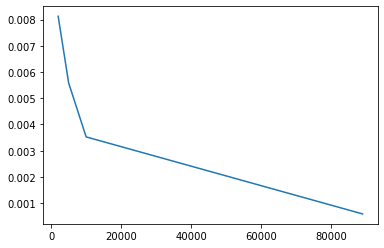

In [19]:
# построим график
x = [2000, 5000, 10000, data.item_id.nunique()]
y = [result['precision_random_2000'].mean(), result['precision_random_5000'].mean(), result['precision_random_10000'].mean(), result['precision_random'].mean()]
plt.plot(x, y)

In [20]:
# метрика по популярным товарам будет одинаковой для всех размеров топ-выборки, так как берем первых 5
# рассчитаем взвешенные случайные рекомендации для топов

In [21]:
items_weights_2000 = popularity[:2000].copy()
items_weights_2000['weight'] = items_weights_2000['sales_value'] / items_weights_2000['sales_value'].sum()
items_weights_2000.drop('sales_value', axis=1, inplace=True)
result['weighted_random_recommendation_2000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights_2000, n=5))

In [22]:
items_weights_5000 = popularity[:5000].copy()
items_weights_5000['weight'] = items_weights_5000['sales_value'] / items_weights_5000['sales_value'].sum()
items_weights_5000.drop('sales_value', axis=1, inplace=True)
result['weighted_random_recommendation_5000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights_5000, n=5))

In [23]:
items_weights_10000 = popularity[:10000].copy()
items_weights_10000['weight'] = items_weights_10000['sales_value'] / items_weights_10000['sales_value'].sum()
items_weights_10000.drop('sales_value', axis=1, inplace=True)
result['weighted_random_recommendation_10000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights_10000, n=5))

In [24]:
result['precision_weighted_2000'] = 0
for i in range(result.shape[0]):
    result.loc[i, 'precision_weighted_2000'] = precision_at_k(result['weighted_random_recommendation_2000'][i], result['actual'][i], k=5)
print(f"Precision@5 для алгоритма Случайные рекомендации для топ 2000: {result['precision_weighted_2000'].mean()}")

Precision@5 для алгоритма Случайные рекомендации для топ 2000: 0.042801175318315655


In [25]:
result['precision_weighted_5000'] = 0
for i in range(result.shape[0]):
    result.loc[i, 'precision_weighted_5000'] = precision_at_k(result['weighted_random_recommendation_5000'][i], result['actual'][i], k=5)
print(f"Precision@5 для алгоритма Случайные рекомендации для топ 5000: {result['precision_weighted_5000'].mean()}")

Precision@5 для алгоритма Случайные рекомендации для топ 5000: 0.03339862879529889


In [26]:
result['precision_weighted_10000'] = 0
for i in range(result.shape[0]):
    result.loc[i, 'precision_weighted_10000'] = precision_at_k(result['weighted_random_recommendation_10000'][i], result['actual'][i], k=5)
print(f"Precision@5 для алгоритма Случайные рекомендации для топ 2000: {result['precision_weighted_10000'].mean()}")

Precision@5 для алгоритма Случайные рекомендации для топ 2000: 0.027032321253672973


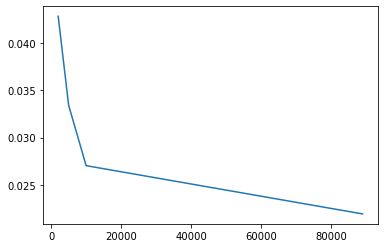

In [27]:
# построим график
x = [2000, 5000, 10000, data.item_id.nunique()]
y = [result['precision_weighted_2000'].mean(), result['precision_weighted_5000'].mean(), result['precision_weighted_10000'].mean(), result['precision_weighted'].mean()]
plt.plot(x, y)

Видим, что график ведет себя так же, как и для случайных рекомендаций, только значения метрик по соответствующим топам выше. 

In [28]:
# Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей  𝐾 . 
# Постройте график зависимости precision@5 от 𝐾
popularity_q = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity_q.rename(columns={'quantity': 'n_sold'}, inplace=True)
top_5000 = popularity_q.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.shape

(2499, 5001)

In [29]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [30]:
%%time
# если запускать циклом, ядро умирает
#for k in range(10):
#    model = ItemItemRecommender(K=k, num_threads=4) # K - кол-во билжайших соседей

#    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
#              show_progress=True)
    
#    result[f'itemitem_{k}_neighbours'] = result['user_id'].\
#    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
#                    model.recommend(userid=userid_to_id[x], 
#                                    user_items=sparse_user_item,   # на вход user-item matrix
#                                    N=5, 
#                                   filter_already_liked_items=True, 
#                                    filter_items=None, 
#                                    recalculate_user=True)])

Wall time: 0 ns


In [30]:
%%time
#для K=1 посчитали в own_purchases, посчитаем для K от 2 до 7, кроме K=5 (это столбец itemitem)
model = ItemItemRecommender(K=2, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem2'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])


Wall time: 643 ms


In [31]:
model = ItemItemRecommender(K=3, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem3'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [32]:
model = ItemItemRecommender(K=4, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem4'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [33]:
model = ItemItemRecommender(K=6, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem6'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [34]:
model = ItemItemRecommender(K=7, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem7'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [35]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation,precision_random,...,weighted_random_recommendation_5000,weighted_random_recommendation_10000,precision_weighted_2000,precision_weighted_5000,precision_weighted_10000,itemitem2,itemitem3,itemitem4,itemitem6,itemitem7
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1029743, 995785, 1004906, 1081177]","[12670788, 6534178, 856772, 883404, 1095100]",0.0,...,"[1018769, 1137346, 6533889, 1074333, 6534178]","[6534178, 1137346, 995965, 874255, 983050]",0.0,0.0,0.0,"[10455984, 12172240, 12810393, 15926844, 12324...","[981760, 6534178, 12324948, 15926844, 12810393]","[981760, 1127831, 1098066, 854852, 866211]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 826249, 878996]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1098066, 6534178, 1127831, 1068719]","[830304, 948670, 865178, 1075998, 968215]",0.0,...,"[962229, 942045, 15972298, 1029743, 1027168]","[5568197, 8203342, 924355, 6534178, 912004]",0.0,0.0,0.0,"[12810393, 13416351, 13945244, 15596279, 13842...","[981760, 13416351, 13842214, 13945244, 15596279]","[981760, 995242, 908531, 840361, 961554]","[981760, 995242, 840361, 1029743, 1004906]","[981760, 995242, 840361, 1029743, 961554]"


In [36]:
result['precision_itemitem2'] = 0
result['precision_itemitem3'] = 0
result['precision_itemitem4'] = 0
#result['precision_itemitem5'] = 0 # =itemitem
result['precision_itemitem6'] = 0
result['precision_itemitem7'] = 0

for i in range(result.shape[0]):
    result.loc[i, 'precision_itemitem2'] = precision_at_k(result['itemitem2'][i], result['actual'][i])
    result.loc[i, 'precision_itemitem3'] = precision_at_k(result['itemitem3'][i], result['actual'][i])
    result.loc[i, 'precision_itemitem4'] = precision_at_k(result['itemitem4'][i], result['actual'][i])
    #result.loc[i, 'precision_itemitem5'] = precision_at_k(result['itemitem5'][i], result['actual'][i])
    result.loc[i, 'precision_itemitem6'] = precision_at_k(result['itemitem6'][i], result['actual'][i])
    result.loc[i, 'precision_itemitem7'] = precision_at_k(result['itemitem7'][i], result['actual'][i])
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation,precision_random,...,itemitem2,itemitem3,itemitem4,itemitem6,itemitem7,precision_itemitem2,precision_itemitem3,precision_itemitem4,precision_itemitem6,precision_itemitem7
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1029743, 995785, 1004906, 1081177]","[12670788, 6534178, 856772, 883404, 1095100]",0.0,...,"[10455984, 12172240, 12810393, 15926844, 12324...","[981760, 6534178, 12324948, 15926844, 12810393]","[981760, 1127831, 1098066, 854852, 866211]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 826249, 878996]",0.0,0.0,0.0,0.0,0.0
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1098066, 6534178, 1127831, 1068719]","[830304, 948670, 865178, 1075998, 968215]",0.0,...,"[12810393, 13416351, 13945244, 15596279, 13842...","[981760, 13416351, 13842214, 13945244, 15596279]","[981760, 995242, 908531, 840361, 961554]","[981760, 995242, 840361, 1029743, 1004906]","[981760, 995242, 840361, 1029743, 961554]",0.2,0.2,0.0,0.0,0.0
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[5129567, 6555376, 9487756, 6533880, 1117945]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1029743, 6534178, 1127831, 995785]","[12810399, 6534178, 10284879, 847239, 847207]",0.0,...,"[12731436, 12731544, 13511722, 15926712, 13003...","[12731436, 12731544, 13511722, 15926712, 13003...","[1058997, 1098066, 916122, 860776, 1005186]","[1098066, 826249, 854852, 1106523, 923746]","[1098066, 826249, 854852, 860776, 923746]",0.0,0.0,0.0,0.0,0.0
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[15740824, 9423981, 1052258, 13986798, 1003354]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 961554, 1098066]","[1082185, 981760, 1127831, 961554, 826249]","[1029743, 1127831, 995785, 1044078]","[1033977, 7168892, 7025046, 933835, 891505]",0.0,...,"[12384775, 12731436, 13511722, 15511891, 12810...","[981760, 12731436, 12810393, 13511722, 15511891]","[981760, 1098066, 883404, 916122, 840361]","[981760, 1098066, 840361, 883404, 6534178]","[981760, 1098066, 840361, 883404, 6534178]",0.0,0.0,0.0,0.0,0.0
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1964658, 954745, 976261, 7025202, 1054432]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1029743, 1098066, 6534178, 1127831]","[1119860, 866878, 9527066, 871756, 831407]",0.0,...,"[12810393, 13115903, 13190294, 15596515, 13189...","[12810393, 13115903, 13190294, 15596515, 13189...","[904360, 13115903, 13189726, 13190294, 15596515]","[904360, 866211, 979707, 13190294, 15596515]","[904360, 866211, 979707, 13190294, 15596515]",0.0,0.0,0.0,0.0,0.0


In [37]:
print(f"Precision@5 для алгоритма Item-Item c K=2: {result['precision_itemitem2'].mean()}")
print(f"Precision@5 для алгоритма Item-Item c K=3: {result['precision_itemitem3'].mean()}")
print(f"Precision@5 для алгоритма Item-Item c K=4: {result['precision_itemitem4'].mean()}")
print(f"Precision@5 для алгоритма Item-Item c K=5: {result['precision_itemitem'].mean()}")
print(f"Precision@5 для алгоритма Item-Item c K=6: {result['precision_itemitem6'].mean()}")
print(f"Precision@5 для алгоритма Item-Item c K=7: {result['precision_itemitem7'].mean()}")

Precision@5 для алгоритма Item-Item c K=2: 0.05949232778321952
Precision@5 для алгоритма Item-Item c K=3: 0.05827619980411406
Precision@5 для алгоритма Item-Item c K=4: 0.0412340842311462
Precision@5 для алгоритма Item-Item c K=5: 0.15112634671890113
Precision@5 для алгоритма Item-Item c K=6: 0.03183153770812942
Precision@5 для алгоритма Item-Item c K=7: 0.03134182174338897


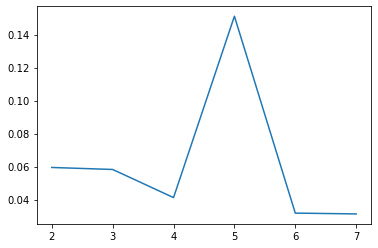

In [39]:
# построим график
x = [K for K in range(2, 8)]
y = [result['precision_itemitem2'].mean(), result['precision_itemitem3'].mean(), result['precision_itemitem4'].mean(), 
     result['precision_itemitem'].mean(), result['precision_itemitem6'].mean(), result['precision_itemitem7'].mean()]
plt.plot(x, y)

In [ ]:
# Честно говоря, не понимаю, почему такие результаты и график. 
# По логике, должны быть чем ближе, тем точнее, а по расчетам получается, что K=5 - оптимальное количество соседей.